# Identificar fronteras no lienales

Veamos un ejemplo de datos en los que no se puede hacer una separación lineal de los puntos tomando las funciones que escribimos antes como punto de partida.

In [38]:
from sklearn.datasets.samples_generator import make_circles, make_blobs
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import numpy as np

In [9]:
X, Y = make_circles(100, factor=.1, noise=.1)

In [36]:
def plt_svc(model, ax=None, plot_support=True):
    
    """Plot de la función de decisión para una clasificación en 2D con SVC"""
    
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    """Generamos la parrilla de puntos para evaluar el modelo
    Nota: usar nombres de variables como xx, yy, X ó Y puede llevar a confusión
    """
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(yy, xx)
        
    """Evaluación del modelo"""
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    """Representamos las fronteras y los márgenes del SVC"""
    ax.contour(X,Y,P, colors = "k", levels=[-1,0,1], alpha = 0.5, linestyles=["--","-","--"])
    
    #print("Vectores de soporte:\n", model.support_vectors_)
    
    if plot_support:
        ax.scatter(model.support_vectors_[:,0],
                   model.support_vectors_[:,1],
                  s=300, linewidth=1, facecolors='red')
        
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

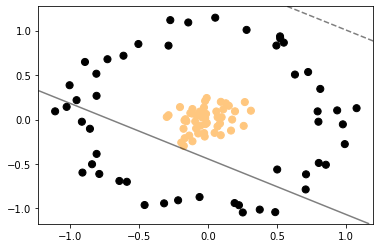

In [17]:
plt.scatter(X[:,0], X[:,1], c=Y, s=50, cmap='copper')
plt_svc(SVC(kernel='linear').fit(X,Y), plot_support=False)

Vemos que no se pueden separar los puntos linealmente.

Para solventar este problema podríamos actuar de varias maneras.

Podríamos **considerar que el problema viene de un espacio de dimensión superior**, de modo que ese separador lineal podría ser un hiperplano separador de esa dimensión superior.

Podríamos aumentar la dimensión añadiendo un separador aleatorio de la siguiente forma.

Si se utiliza una función gausiana para ello:
* Una campana de gauss centrada en cero, con la cúpula correspondiendo a los datos coloreados de naranja y en negro las colas
* La expresión de la campana es $\sum e^{-x^2} = 1$
* Obtenemos r: la altura correspondiente de los puntos del conjunto que ya teníamos

In [19]:
r = np.exp(-(X**2).sum(1))

Hacemos lo siguiente para visualizar lo que acabamos de hacer.

In [20]:
from mpl_toolkits import mplot3d

In [28]:
def plot_3D(X=X, Y=Y, r=r, elev=30, azim=30):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:,0],X[:,1], r, c=Y, s=50, cmap='copper')
    ax.view_init(elev=elev, azim=azim)
    
    ax.set_xlabel("x[0]")
    ax.set_ylabel("y[1]")
    ax.set_zlabel("r")

Le añadimos la función interactiva para estudiar el comportamiento de la clasificación en este caso.

In [29]:
from ipywidgets import interact, fixed

In [31]:
interact(plot_3D, elev=[-90,-60, -30, 0, 30, 60 ,90],
         azim=[-180, -150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150, 180], 
         X=fixed(X), Y=fixed(Y), r=fixed(r))

interactive(children=(Dropdown(description='elev', index=4, options=(-90, -60, -30, 0, 30, 60, 90), value=30),…

<function __main__.plot_3D(X=array([[-8.91077916e-01,  6.47538168e-01],
       [-9.13527557e-01, -2.48560929e-02],
       [ 9.75653946e-01, -5.42440524e-02],
       [-3.18352500e-01, -9.43090646e-01],
       [ 5.18141523e-02,  1.14557886e+00],
       [-1.28336253e-01,  7.25305250e-02],
       [ 5.00408768e-01, -5.62294869e-01],
       [ 7.24223269e-01,  5.34466675e-01],
       [-8.55115314e-01, -1.04041076e-01],
       [ 8.01410983e-01, -4.88619502e-01],
       [-1.70626488e-01, -8.88645871e-03],
       [-7.87433456e-01, -6.12472376e-01],
       [ 8.61206613e-02, -4.47345330e-02],
       [-1.36402284e-01, -1.80416549e-01],
       [-8.06910972e-01, -3.86786350e-01],
       [-2.16953850e-01, -9.08725158e-01],
       [ 2.57882848e-01, -7.16629327e-02],
       [-2.85405941e-02, -1.52598096e-01],
       [-8.66008807e-02, -1.00671703e-01],
       [-6.42011073e-01, -6.91163988e-01],
       [-1.69415021e-01, -2.10341219e-01],
       [ 1.94996430e-01,  9.23771077e-02],
       [ 1.66071963e-01, 

Como vemos, en los casos resultantes (en todas las combinaciones) se puede establecer un hiperplano que separe linealmente los datos. Si embargo, esto ha sido posible al agregar una dimensión a los datos y al resultar que esta permitió la separación lineal mediante un hiperplano.

En general, hacer una elección así será un problema de difícil solución, además de que computacionalmente puede resultar muy costoso, y no vamos a poder conseguir aumentar el espacio vectorial y que funciones de forma tan trivial, sino que habrá que buscar otro tipo de técnica en la que poder basarnos y que funcione en la gran mayoría de casos de análisis.

### El kernel no lineal

La técnica consistirá en transformar los datos de forma implícita sin necesidad de construir un espacio n-dimensional sobre el cual proyectar de vuelta al espacio de partida.

El "truco" se basa en pasarle al kernel un parámetro no lineal, que este realice una separación lineal en un espacio de dimensión superior de tal manera que luego seamos capaces de proyectarla sobre nuestro espacio bi-direccional de vuelta.

La librería `sklearn` lo trae implementado. Le pasaremos como parámetro al kernel el método `RDF` (Radial Bases Function), que lo que hace es intentar buscar formas circulares que separen nuestros datos.

In [33]:
rbf=SVC(kernel='rbf', C=1E6)
rbf.fit(X,Y)

/Users/carlosdavila/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

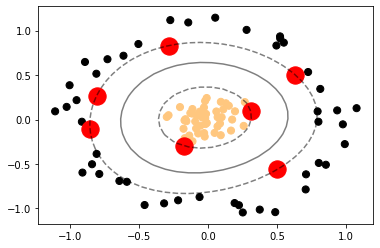

In [37]:
plt.scatter(X[:,0],X[:,1], c=Y, s=50, cmap='copper')
plt_svc(rbf)
plt.scatter(rbf.support_vectors_[:,0],rbf.support_vectors_[:,1], s=300, lw=1, facecolors='none')

Vemos como el algoritmo ha sido capaz de realizar la separación tomando un kernel no lineal.

Para más información sobre los kernel del `SVC` se puede visitar la [documentación del paquete SVC de sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

## Ajustar los parámetros de SVM

En casos en los que la distribución no sea tan clara como la anterior o los puntos estén claramente diferenciados, la SVM dará clasificaciones con superposiciones. Es decir, puntos (siempre de una determinada categoría) mal clasificados.

In [43]:
X, Y = make_blobs(n_samples=100, centers=2, random_state=0, cluster_std=1.2)

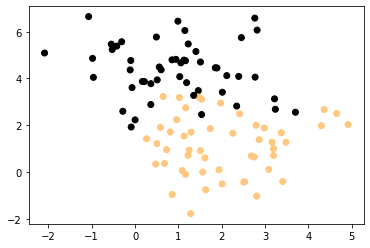

In [44]:
plt.scatter(X[:,0],X[:,1], c=Y, cmap = 'copper')

Como vemos, en este caso, los datos que hemos creados arrojan una distribución dificilmente separable un caso de otro.

La SVM tiene un factor cuya función es relajar las restricciones de margen. Es decir, permite que algunos puntos estén en el margen cambiado, lo que resulta en un mejor ajuste, a espensas de que algún punto quede mal clasificado.

Para hacer que el margen quede reducido se tomará el parámetro `C` (parámetro de la penalización):
* Para valores muy altos de C el margen será muy restringido y los puntos no podrán siquiera estar dentro de esos márgenes
* Para valores pequeños de C, el margen será mucho más suave y permitirá que los puntos caigan en ese corredor sin problemas

Para ejemplificarlo, crearemos otra distribución de datos con algo menos de desviación estandar.

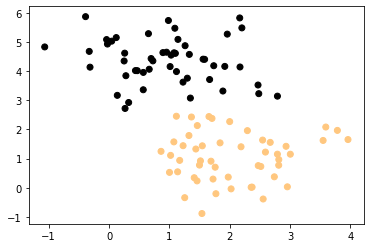

In [47]:
X, Y = make_blobs(n_samples=100, centers=2, random_state=0, cluster_std=0.8)
plt.scatter(X[:,0],X[:,1], c=Y, cmap = 'copper')

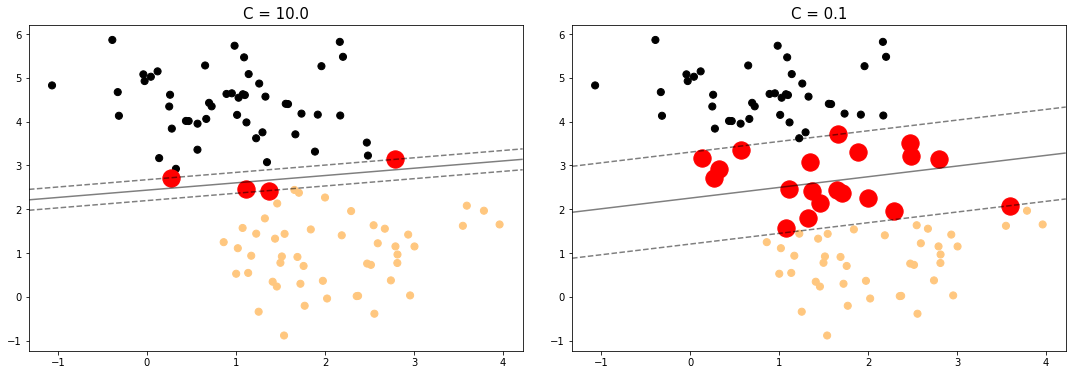

In [50]:
fig, ax = plt.subplots(1,2, figsize=(16,6))

# ajustamos los parametros de espacio a la izquierda, derecha y central
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.1)

for ax_i, C in zip(ax, [10.0,0.1]):
    model = SVC(kernel='linear', C=C)
    model.fit(X,Y)
    ax_i.scatter(X[:,0],X[:,1], c=Y, s=50, cmap='copper')
    plt_svc(model, ax_i)
    ax_i.set_title("C = {0:.1f}".format(C), size=15)

En el plot anterior vemos la diferencia entre establecer un margen rígido (C=10), donde queremos que el corredor sea estrecho y que haya el mínimo número de puntos que caigan dentro; y el segundo caso, con un margen mucho más laxo (C=0.1), en el que el pasillo es más ancho y una mayor cantidad de vectores (datos) caen dentro del mismo.

Al no existir una técnica de optimización del parámetro C dentro del modelo, tendríamos que ir probando valores hasta conseguir una clasificación lo más adecuada posible. Dependerá del data set que se esté trabajando y muchas veces tendremos que emplear la validación cruzada o algún procedimiento para poder tunear estos hiperparámetros y validar que el modelo es correcto.

**Habrá que ir con cuidado de no establecer un hiperparámetro `C` muy alto en los casos en los que la separación no esté clara, ya que esto puede conllevar un alto coste computacional.**